## AccelerateAI - Time Series Analysis and Forecasting

### Time Series Forecasting - Smoothing Methods

In [37]:
import pandas as pd 

from statsmodels.tsa.seasonal import seasonal_decompose, STL

import matplotlib as mpl
mpl.rc("figure", figsize=(10,8))
import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
airpassenger = pd.read_csv("air_passenger.csv", parse_dates=True, index_col="Date")
airpassenger.tail()

,DOMESTIC
Date,
2021-01-01,24305904.0
2021-02-01,24482882.0
2021-03-01,39312542.0
2021-04-01,43800484.0
2021-05-01,52513857.0


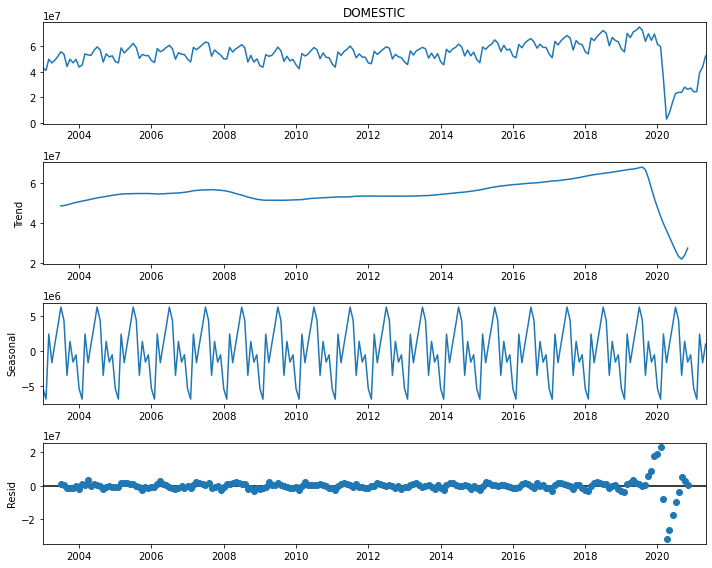

In [78]:
# Decompose the Time series
result = seasonal_decompose(airpassenger.DOMESTIC)
fig = result.plot()

In [117]:
airpassenger = airpassenger.iloc[:204]

### 1. Naive Forecast

In [168]:
airpassenger['Naive'] = airpassenger.DOMESTIC.shift(12)
airpassenger.tail()

,DOMESTIC,Naive,MA-12,SES,Holt-DES,HW-TES,Holt,HW
Date,,,,,,,,
2019-08-01,72729199.0,70338563.0,6.657579e+07,7.315064e+07,7.319600e+07,7.295188e+07,7.380790e+07,7.315064e+07
2019-09-01,63991365.0,60468575.0,6.686935e+07,6.751662e+07,6.475925e+07,6.486137e+07,6.743815e+07,6.751662e+07
2019-10-01,69936836.0,67082086.0,6.710725e+07,6.900533e+07,6.972367e+07,6.944404e+07,6.932116e+07,6.900533e+07
2019-11-01,64827417.0,64660022.0,6.712120e+07,6.643543e+07,6.527496e+07,6.527566e+07,6.644065e+07,6.643543e+07
2019-12-01,69737438.0,63646582.0,6.762877e+07,NaN,6.956938e+07,6.930423e+07,NaN,NaN


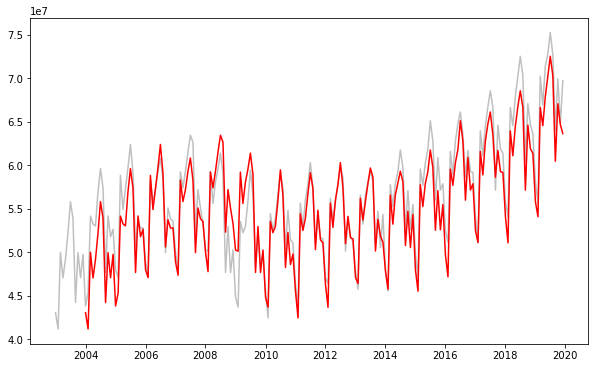

In [119]:
# How well does the naive forecast fit the data?
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(airpassenger.DOMESTIC, color='.5', alpha=.5)
ax.plot(airpassenger.Naive, color='r')

### 2. Moving Average

In [120]:
airpassenger['MA-12'] = airpassenger.DOMESTIC.rolling(12).mean()

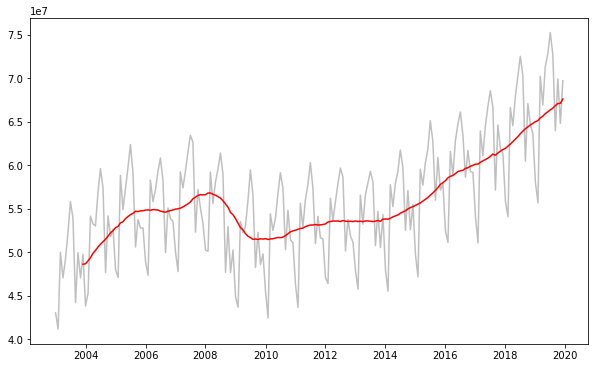

In [121]:
# How well does the MA-12 forecast fit the data?
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(airpassenger.DOMESTIC, color='.5', alpha=.5)
ax.plot(airpassenger["MA-12"], color='r')

### 3. Simple Exponential Smoothing, Holt Method & Holt Winter's Method

In [122]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing          # Simple 
from statsmodels.tsa.holtwinters import Holt                        # Holt's Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing        # Holt Winter's Exponential Smoothing

In [123]:
SE_fit = SimpleExpSmoothing(airpassenger.DOMESTIC).fit() 
Holt_fit = Holt(airpassenger.DOMESTIC).fit() 
HoltWinter_fit = ExponentialSmoothing(airpassenger.DOMESTIC).fit()

C:\Users\sachi\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\sachi\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\sachi\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


##### For some reason, when optimized=False is passed into .fit(), the statsmodels SimpleExpSmoothing function shifts fitted values down one row. We fix this by adding .shift(-1) after .fittedvalues

In [124]:
airpassenger['SES'] = SE_fit.fittedvalues.shift(-1)
airpassenger['Holt'] = Holt_fit.fittedvalues.shift(-1)
airpassenger['HW'] = HoltWinter_fit.fittedvalues.shift(-1) 

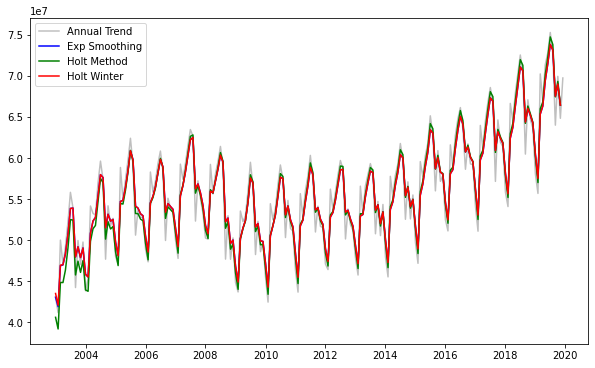

In [125]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(airpassenger.DOMESTIC, color='.5', alpha=.5, label='Annual Trend')
ax.plot(airpassenger.SES, color='b', label='Exp Smoothing')
ax.plot(airpassenger.Holt, color='g', label='Holt Method')
ax.plot(airpassenger.HW, color='r', label='Holt Winter')
ax.legend()

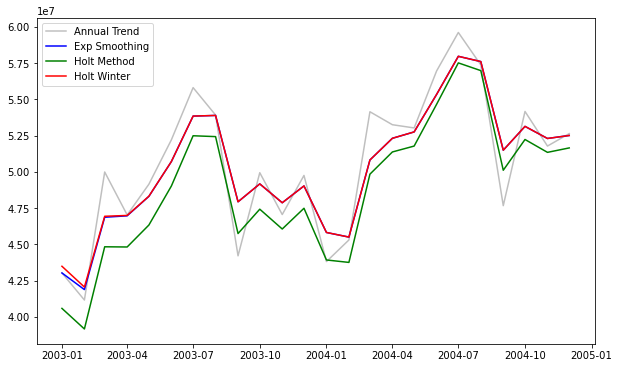

In [126]:
# Let's look a bit closely
ap = airpassenger.iloc[0:24]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(ap.DOMESTIC, color='.5', alpha=.5, label='Annual Trend')
ax.plot(ap.SES, color='b', label='Exp Smoothing')
ax.plot(ap.Holt, color='g', label='Holt Method')
ax.plot(ap.HW, color='r', label='Holt Winter')
ax.legend()

### Forecasting using Exponential Smoothing

In [144]:
# Split into train and test set
train_ts = airpassenger[:180] 
test_ts = airpassenger[180:] 
len(test_ts)

24

In [145]:
airpassenger.index.freq = 'MS'
HW_model = ExponentialSmoothing(train_ts.DOMESTIC, 
                                trend='add', 
                                seasonal='add',
                                seasonal_periods=12).fit()

C:\Users\sachi\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [146]:
HW_forecast = HW_model.forecast(24).rename('HW Forecast')

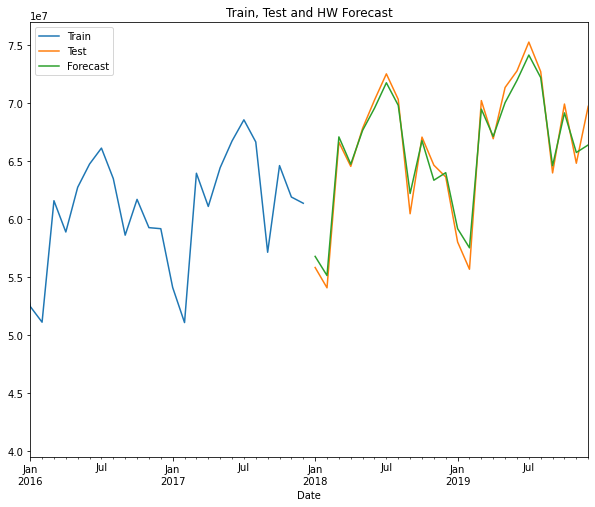

In [147]:
train_ts['DOMESTIC'].plot(legend=True,label='Train')
test_ts['DOMESTIC'].plot(legend=True,label='Test')
HW_forecast.plot(legend=True,label='Forecast', xlim=['2016-01-01','2019-12-01'])
plt.title('Train, Test and HW Forecast');

In [156]:
# Calculate RMSE or MAPE
import math
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [158]:
print(f'HW Forecast RMSE = {math.sqrt(mean_squared_error(test_ts.DOMESTIC,HW_forecast))}')

RMSE = 1132312.0750699474


In [155]:
print(f'HW Forecast MAPE = {mean_absolute_percentage_error(test_ts.DOMESTIC,HW_forecast)}')

MAPE = 0.01403761678980111


In [169]:
naive_fcst = airpassenger['Naive'][180:] 
print(f'HW Forecast MAPE = {mean_absolute_percentage_error(test_ts.DOMESTIC, naive_fcst)}')

HW Forecast MAPE = 0.043729829057689844


#### Since MAPE for Holt Winter forecast, it much smaller that Naive forecast, we can use the HW forecast !

***